In [1]:
import pandas as pd
df=pd.read_csv('./data/neurips.csv')

In [2]:
df.head()

,year,title,abstract
0,2007,Competition Adds Complexity,It is known that determinining whether a DEC-P...
1,2007,Efficient Principled Learning of Thin Junction...,We present the first truly polynomial algorith...
2,2007,Regularized Boost for Semi-Supervised Learning,Semi-supervised inductive learning concerns ho...
3,2007,Simplified Rules and Theoretical Analysis for ...,We show that under suitable assumptions (prima...
4,2007,Predicting human gaze using low-level saliency...,"Under natural viewing conditions, human observ..."


In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
cv=TfidfVectorizer(stop_words='english', max_features=2000)
x=cv.fit_transform(df.abstract)

In [5]:
words= cv.get_feature_names()

C:\Users\JangSeongHyun\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [6]:
from gensim.matutils import Sparse2Corpus

In [7]:
corpus=Sparse2Corpus(x.T)

In [8]:
#단어사전을 만드는 것
id2token=dict(enumerate(words))

In [9]:
id2token[9]

'abstract'

In [10]:
import re
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

In [11]:
token_re=re.compile(r'\b\w{2,}\b', re.UNICODE)
#단어가 2개 이상이 아닌것은 제외

In [12]:
token_re.findall('ㅂ')

[]

In [13]:
def tokenizer(text):
    text=text.lower() #소문자
    words=[]
    for word in token_re.findall(text):
        if word not in ENGLISH_STOP_WORDS:    #불용어 제외
            words.append(word)
    return words

In [14]:
#docs = 문서별로 단어들 리스트로 묶은것
docs=[]
for text in df.abstract:
    doc=tokenizer(text)
    docs.append(doc)

In [15]:
from gensim.corpora.dictionary import Dictionary

In [16]:
# 문서별 단어들을 가지고 단어사전을 만들게 된다
dic=Dictionary(docs)

In [17]:
dic.filter_extremes(no_below=10, no_above=0.9)
#no_below 10개 이하의 문서에서 나온 단어는 없앤다(너무 적어서)
#no_above 전체의 90%의 문서에서 나온 단어는 없앤다(너무 흔해서)

In [18]:
dic[0]

'affected'

전체문서에 대한 단어구름 만들기

In [19]:
docs1=sum(docs,[])
bow1=dic.doc2bow(docs1)

In [121]:
for i in range(len(bow1)):
    a=list(bow1[i])
    a[0]=dic[i]
    bow1[i]=tuple(a)

In [122]:
bow1.sort(key=lambda x:x[1],reverse = True)

In [125]:
from wordcloud import WordCloud

In [126]:
wc= WordCloud(background_color='white', max_words=100, width=400, height=300)

In [127]:
cloud=wc.fit_words(dict(bow1))

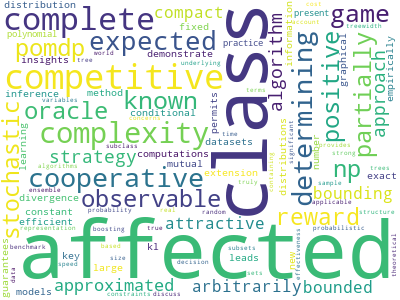

In [128]:
cloud.to_image()

끝

In [27]:
corpus=[]
for doc in docs:
    bow=dic.doc2bow(doc)  #bow(bag of words): 단어들이 몇개씩 나왔는지 세서 묶어놓는다
    corpus.append(bow)

In [41]:
corpus[3100] #sklearn의 CounterVectorizer 와 비슷하다. 문서별 단어들이 몇번씩 나왔는지 센것이다.

[(1069, 0.10934058859849045),
 (1238, 0.25155676242935304),
 (577, 0.24728094604266063),
 (1272, 0.11542862837026654),
 (334, 0.11072241954951556),
 (1673, 0.13245199942678396),
 (1050, 0.4183156958932214),
 (1308, 0.11786304308470934),
 (120, 0.138496698238783),
 (251, 0.13073693505048378),
 (1697, 0.14177289509493857),
 (1176, 0.23028234735261427),
 (1081, 0.20863760217522212),
 (1331, 0.08908788878502108),
 (506, 0.13129495425251245),
 (311, 0.08630528141797184),
 (622, 0.10063731347538482),
 (1226, 0.09704819397668181),
 (1053, 0.08514823624370031),
 (450, 0.16135421896587307),
 (1197, 0.06604305953174232),
 (1461, 0.09799962847164796),
 (1794, 0.1058131360951666),
 (1397, 0.061617458677365074),
 (1279, 0.07691672601236497),
 (1617, 0.12405291336293399),
 (760, 0.07236608412885426),
 (1321, 0.13701404536047382),
 (799, 0.09335451862855106),
 (621, 0.09488503170855482),
 (1271, 0.24567301430336802),
 (337, 0.09928181758746643),
 (656, 0.06440691277199999),
 (1933, 0.1075418421852642

In [36]:
from gensim.models.ldamodel import LdaModel

In [37]:
from sklearn.model_selection import train_test_split
train_corpus, valid_copus =train_test_split(corpus, test_size=0.1, random_state=5432)
#데이터 분할, LDA 모델에서 추정할때 언제까지 할지 정하기 힘들어
#추정할때마다 validation으로 test 해서 괜찮은지 볼것이다.

In [38]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [39]:
model = LdaModel(corpus=train_corpus, id2word=dic, num_topics=100, random_state=1234)
#num_topic 주제 수
#id2word  는 번호와 단어가 짝찌어져있는 dic를 넣어준다.

In [40]:
# 혼합성
#교차엔트로피든 혼합성(loss)든 0에 가까워야 좋은 것
loss=model.log_perplexity(valid_copus)
loss 

-20.28818576219254

In [41]:
import numpy
old_loss=-numpy.inf
while loss >old_loss +0.1:
    model.update(train_corpus)
    old_loss=loss
    loss=model.log_perplexity(valid_copus)
    print(loss)
#시간이 많다면 0.1 대신 0.01도 해보자

-18.41543955126969
-17.327568585837554
-16.73147380947736
-16.387525533265627
-16.174279306740893
-16.03155578035293
-15.928847548497595
-15.850707034768668


In [42]:
model.save('lda-model')

In [43]:
!zip mylda.zip lda-model*

'zip'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [44]:
model= LdaModel.load('lda-model')

In [45]:
model.show_topic(0)
# 주제마다 어떤 단어들이 많이 나오는지 알 수 있다.

[('algorithm', 0.032629453),
 ('problem', 0.022747029),
 ('optimal', 0.020124905),
 ('algorithms', 0.015991433),
 ('convex', 0.013323052),
 ('statistical', 0.012536754),
 ('number', 0.0107658915),
 ('optimization', 0.01070688),
 ('performance', 0.009536926),
 ('experiments', 0.009430568)]

In [46]:
dic.token2id['topic']
#특정 단어의 번호

307

In [47]:
model.get_term_topics(307, 0.01)
#특정단어의 번호가 1% 이상 나온 주제

[(8, 0.07096321)]

In [48]:
model.show_topic(8)
#특정 주제의 단어를 보는 것

[('topic', 0.07098466),
 ('model', 0.044736568),
 ('latent', 0.031269457),
 ('dirichlet', 0.030933257),
 ('topics', 0.02808891),
 ('word', 0.026063984),
 ('models', 0.025641274),
 ('document', 0.025310298),
 ('lda', 0.02515878),
 ('words', 0.024487654)]

In [49]:
new_text = '''We describe latent Dirichlet allocation (LDA), a generative probabilistic model for collections of
discrete data such as text corpora. LDA is a three-level hierarchical Bayesian model, in which each
item of a collection is modeled as a finite mixture over an underlying set of topics. Each topic is, in
turn, modeled as an infinite mixture over an underlying set of topic probabilities. In the context of
text modeling, the topic probabilities provide an explicit representation of a document. We present
efficient approximate inference techniques based on variational methods and an EM algorithm for
empirical Bayes parameter estimation. We report results in document modeling, text classification,
and collaborative filtering, comparing to a mixture of unigrams model and the probabilistic LSI
model.'''
# LDA에 관한 문서이다

In [50]:
#새로운 문서가 있을 때 이 문서는 어떤 주제들이 들어있는가를 보기 위한 것
doc=tokenizer(new_text)
bow=dic.doc2bow(doc)

In [51]:
model.get_document_topics(bow)
#LDA 문서이기 때문에 topic이 가중치가 큰 주제가 44% 들어있는 것으로 보인다.

[(1, 0.09356345),
 (8, 0.44195318),
 (12, 0.06747891),
 (14, 0.084951885),
 (22, 0.06507167),
 (44, 0.017240101),
 (54, 0.062440388),
 (78, 0.050478034),
 (96, 0.104003765)]

In [52]:
import pyLDAvis.gensim

In [53]:
pyLDAvis.enable_notebook()

C:\Users\JangSeongHyun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
p=pyLDAvis.gensim.prepare(model, corpus, dic, sort_topics=False)

C:\Users\JangSeongHyun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
pyLDAvis.display(p)
#Slide to adjust relevance metric 1에 가까우면 절대적으로 이 주제에 많이 나오는 것
#                                 0에 가까우면 상대적으로 평소에 덜 나오는 단어에 따라 달라짐, 주로 0.6정도가 좋은데 한번 해보고 판단 (관련성)
#현저성(Salient)은 쓰임새도 많으면서 주제에 영향이 큰 단어가 현저성이 높다고 한다.

C:\Users\JangSeongHyun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
from gensim.models import CoherenceModel

C:\Users\JangSeongHyun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
coh=CoherenceModel(model=model, corpus= corpus, texts=docs,dictionary=dic, coherence='c_v')

C:\Users\JangSeongHyun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
coh.get_coherence()
#응집도 계산: 높으면 높을수록 좋은 것이다.

C:\Users\JangSeongHyun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.3595160905498011

In [75]:
#다양도 분석 - 주제마다 25개의 상위단어를 본다
topn=25
top_words=set()

for topic in range(model.num_topics):
    for word, prob in model.show_topic(topic, topn=topn):
        top_words.add(word)

C:\Users\JangSeongHyun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
len(top_words)

C:\Users\JangSeongHyun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1069

In [78]:
len(top_words)/2500
# 주제별 상위 25개의 단어를 결합하였는데 중복된것을 뺐더니 2500개 중 42%만 남았다
# 주제의 다양도가 42%인것이다.
# 다양도 또한 높을수록 좋은 것이다.

C:\Users\JangSeongHyun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.4276